In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

from modAL.models import ActiveLearner,Committee
from modAL.uncertainty import uncertainty_sampling, entropy_sampling,margin_sampling

from keras.datasets import imdb

2024-10-06 00:56:46.341166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 00:56:46.358497: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 00:56:46.363413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 00:56:46.375875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

In [3]:
word_index = imdb.get_word_index()
index_word = {value: key for (key, value) in word_index.items()}

In [4]:
def decode_review(review):
    return " ".join([index_word.get(i - 3, "?") for i in review])

In [5]:
X_train_text = [decode_review(review) for review in X_train]
X_test_text = [decode_review(review) for review in X_test]

In [6]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

In [7]:
initial_idx = np.random.choice(range(X_train_tfidf.shape[0]), size=100, replace=False)
X_initial, y_initial = X_train_tfidf[initial_idx], y_train[initial_idx]

In [8]:
X_pool = np.delete(X_train_tfidf.toarray(), initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [18]:
# Naive Bayes with Uncertainty Sampling
learner_uncertainty = ActiveLearner(
    estimator=SVC(probability=True),
    query_strategy=uncertainty_sampling,
    X_training=X_initial,
    y_training=y_initial,
)

In [19]:
# Naive Bayes with Entropy Sampling
learner_entropy = ActiveLearner(
    estimator=SVC(probability=True),
    query_strategy=entropy_sampling,
    X_training=X_initial,
    y_training=y_initial,
)

In [20]:
# Naive Bayes with Margin Sampling
learner_margin = ActiveLearner(
    estimator=SVC(probability=True),
    query_strategy=margin_sampling,
    X_training=X_initial,
    y_training=y_initial,
)

In [21]:
n_queries = 50
performance_uncertainty = []
performance_entropy = []
performance_margin = []

In [22]:
def run_active_learning(learner, X_pool, y_pool, strategy_name):
    """Keeps the loop running and capture the performance of the model"""
    performance = []
    for i in range(n_queries):
        query_idx, _ = learner.query(X_pool)
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(
            y_pool, query_idx, axis=0
        )
        y_pred = learner.predict(X_test_tfidf)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        performance.append((acc, f1))
        print(
            f"{strategy_name} | Query {i+1}: Accuracy = {acc:.4f}, F1-Score = {f1:.4f}"
        )
    return performance

In [23]:
for strategy, learner in zip(
    ["Uncertainty Sampling", "Entropy Sampling", "Margin Sampling"],
    [learner_uncertainty, learner_entropy, learner_margin],
):
    # Reset the pools for each learner
    X_pool = np.delete(X_train_tfidf.toarray(), initial_idx, axis=0)
    y_pool = np.delete(y_train, initial_idx, axis=0)

    # Run active learning
    performance = run_active_learning(learner, X_pool.copy(), y_pool.copy(), strategy)

    if strategy == "Uncertainty Sampling":
        performance_uncertainty = performance
    elif strategy == "Entropy Sampling":
        performance_entropy = performance
    elif strategy == "Margin Sampling":
        performance_margin = performance

Uncertainty Sampling | Query 1: Accuracy = 0.5381, F1-Score = 0.1473
Uncertainty Sampling | Query 2: Accuracy = 0.5495, F1-Score = 0.1879
Uncertainty Sampling | Query 3: Accuracy = 0.5804, F1-Score = 0.2939
Uncertainty Sampling | Query 4: Accuracy = 0.6244, F1-Score = 0.4272
Uncertainty Sampling | Query 5: Accuracy = 0.6709, F1-Score = 0.5556
Uncertainty Sampling | Query 6: Accuracy = 0.7194, F1-Score = 0.6801
Uncertainty Sampling | Query 7: Accuracy = 0.7266, F1-Score = 0.7422
Uncertainty Sampling | Query 8: Accuracy = 0.6902, F1-Score = 0.7397
Uncertainty Sampling | Query 9: Accuracy = 0.7278, F1-Score = 0.7430
Uncertainty Sampling | Query 10: Accuracy = 0.7208, F1-Score = 0.6832
Uncertainty Sampling | Query 11: Accuracy = 0.6827, F1-Score = 0.5827
Uncertainty Sampling | Query 12: Accuracy = 0.7148, F1-Score = 0.6712
Uncertainty Sampling | Query 13: Accuracy = 0.6773, F1-Score = 0.5723
Uncertainty Sampling | Query 14: Accuracy = 0.6344, F1-Score = 0.4547
Uncertainty Sampling | Query 

In [24]:
acc_uncertainty, f1_uncertainty = zip(*performance_uncertainty)
acc_entropy, f1_entropy = zip(*performance_entropy)
acc_margin, f1_margin = zip(*performance_margin)
sns.set(style="whitegrid")

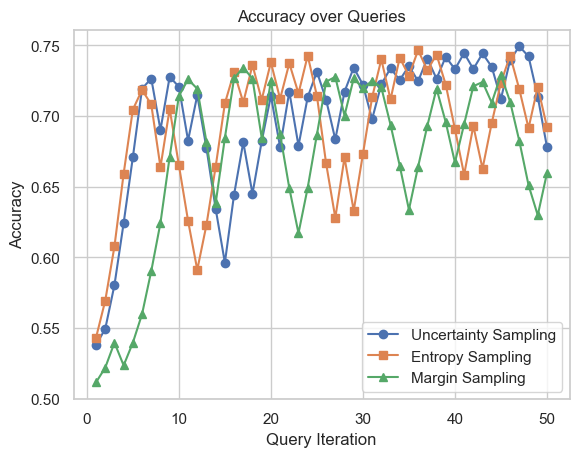

In [25]:
plt.plot(
    range(1, n_queries + 1), acc_uncertainty, label="Uncertainty Sampling", marker="o"
)
plt.plot(range(1, n_queries + 1), acc_entropy, label="Entropy Sampling", marker="s")
plt.plot(
    range(1, n_queries + 1), acc_margin, label="Margin Sampling", marker="^"
)
plt.title("Accuracy over Queries")
plt.xlabel("Query Iteration")
plt.ylabel("Accuracy")
plt.legend()

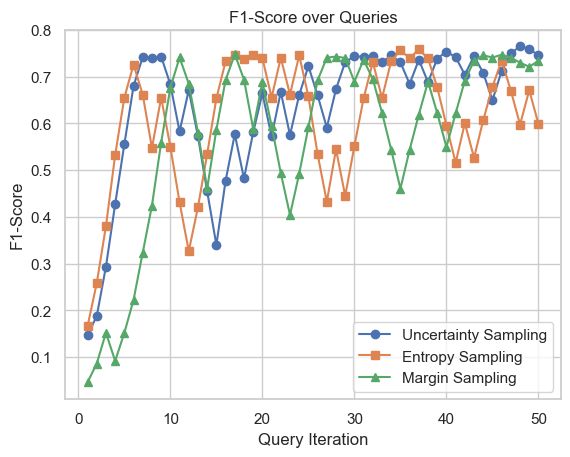

In [26]:
plt.plot(
    range(1, n_queries + 1), f1_uncertainty, label="Uncertainty Sampling", marker="o"
)
plt.plot(range(1, n_queries + 1), f1_entropy, label="Entropy Sampling", marker="s")
plt.plot(
    range(1, n_queries + 1), f1_margin, label="Margin Sampling", marker="^"
)
plt.title("F1-Score over Queries")
plt.xlabel("Query Iteration")
plt.ylabel("F1-Score")
plt.legend()